In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import torch
import json
import data.utils as utils
sys.modules['utils'] = utils # Way to get around relative imports in utils for ZeoSynGen_dataset # https://stackoverflow.com/questions/2121874/python-pickling-after-changing-a-modules-directory
from einops import repeat
from models.cvae import CVAEv1, CVAEv2
from data.metrics import maximum_mean_discrepancy

/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
model_type = 'cvae' # 'cvae'
fname = 'v10'
split = 'system'

In [3]:
# Load configs
with open(f'runs/{model_type}/{split}/{fname}/configs.json') as f:
    configs = json.load(f)
with open(f"runs/{model_type}/{split}/{fname}/train_loss_list.pkl", 'rb') as f: # load dataset
    train_loss_list = pickle.load(f)
with open(f"runs/{model_type}/{split}/{fname}/recons_loss_list.pkl", 'rb') as f: # load dataset
    recons_loss_list = pickle.load(f)
with open(f"runs/{model_type}/{split}/{fname}/kld_loss_list.pkl", 'rb') as f: # load dataset
    kld_loss_list = pickle.load(f)
with open(f"runs/{model_type}/{split}/{fname}/val_loss_list.pkl", 'rb') as f: # load dataset
    val_loss_list = pickle.load(f)

/tmp/ipykernel_569562/1524880275.py:9: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,1.1*train_loss_list[0])


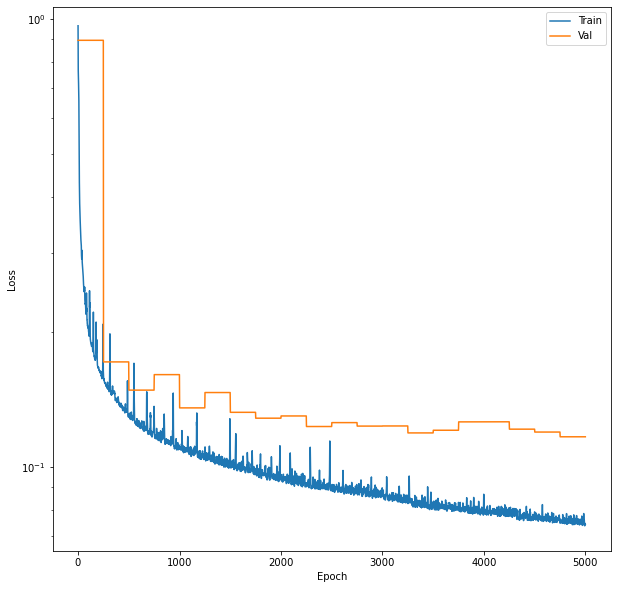

In [4]:
# Train/val loss fig
plt.figure(figsize=(10,10))
plt.plot(range(len(train_loss_list)), train_loss_list, label = 'Train')
plt.plot(range(len(val_loss_list)), val_loss_list, label = 'Val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.ylim(0,1.1*train_loss_list[0])
plt.show()

In [5]:
# Load model
# model = CVAEv1(**configs['model_params'])
model = CVAEv2(**configs['model_params'])

model.load_state_dict(torch.load(f'runs/{model_type}/{split}/{fname}/best_model.pt', map_location=configs['device']))
model = model.to(configs['device'])
model.eval()

# Load test set
with open(f'data/ZeoSynGen_dataset.pkl', 'rb') as f: # load dataset
    dataset = pickle.load(f)
_, _, test_dataset = dataset.train_val_test_split(mode=split, both_graph_feat_present=True, random_state=0) # Note, here we filter out points with no graph/feature present for either zeolite and OSDA

# Get test zeolites and OSDAs
zeo_code, zeo, osda_smiles, osda, = test_dataset[3], test_dataset[5], test_dataset[13], test_dataset[15], 

if not os.path.isfile(f'runs/{model_type}/{split}/{fname}/syn_pred_agg.csv'): # If synthetic predictions not already saved
    print('Systems not predicted yet, predicting and saving...')
    # Predict synthesis conditions
    zeo_code = repeat(np.array(zeo_code), 'n -> (repeat n)', repeat = 50)
    zeo = repeat(zeo, 'n d -> (repeat n) d', repeat = 50)
    osda_smiles = repeat(np.array(osda_smiles), 'n -> (repeat n)', repeat = 50)
    osda = repeat(osda, 'n d -> (repeat n) d', repeat = 50)
    zeo, osda = zeo.to(configs['device']), osda.to(configs['device'])
    syn_pred = torch.tensor(model.predict(zeo, osda).cpu().detach().numpy())

    # Scale synthesis conditions back
    for ratio_idx, ratio in enumerate(dataset.ratio_names+dataset.cond_names):
        qt = dataset.qts[ratio] # load quantile transformer
        syn_pred[:,ratio_idx] = torch.tensor(qt.inverse_transform(syn_pred[:,ratio_idx].reshape(-1, 1))).reshape(-1) # transform back
    syn_pred = pd.DataFrame(syn_pred, columns=dataset.ratio_names+dataset.cond_names)
    syn_pred['zeo'], syn_pred['osda'] = zeo_code, osda_smiles
    syn_pred.to_csv(f'runs/{model_type}/{split}/{fname}/syn_pred_agg.csv', index=False) # Save synthetic predictions
    
else:
    print('Loading synthetic predictions from saved predictions...')
    syn_pred = pd.read_csv(f'runs/{model_type}/{split}/{fname}/syn_pred_agg.csv')

syn_pred_scaled = utils.scale_x_syn_ratio(syn_pred, dataset) # get min-max scaled version too

syn_pred.shape

SYSTEMS:
train+val: 1856 test: 464

n_datapoints:
train: 14749 val: 2107 test: 5168
Loading synthetic predictions from saved predictions...


(258400, 14)

In [6]:
# Get ground truth
syn_true, zeo_code, osda_smiles = test_dataset[1], test_dataset[3], test_dataset[13]
for ratio_idx, ratio in enumerate(dataset.ratio_names+dataset.cond_names):
    qt = dataset.qts[ratio] # load quantile transformer
    syn_true[:,ratio_idx] = torch.tensor(qt.inverse_transform(syn_true[:,ratio_idx].reshape(-1, 1))).reshape(-1) # transform back
syn_true = pd.DataFrame(syn_true, columns=dataset.ratio_names+dataset.cond_names)
syn_true = pd.DataFrame(syn_true, columns=dataset.ratio_names+dataset.cond_names)
syn_true['zeo'], syn_true['osda'] = zeo_code, osda_smiles

syn_true_scaled = utils.scale_x_syn_ratio(syn_true, dataset) # get min-max scaled version too

syn_true.shape

(5168, 14)

# Aggregated

In [7]:
a = np.array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], 
            #   [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
              ])
np.concatenate([a, a], axis=0)

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [8]:
a = np.array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], 
              [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
              ])
b = np.array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], 
              [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
              ])
maximum_mean_discrepancy(a, b)

-4.241944313049316

In [9]:
# plt.figure(figsize=(5,5))
# mmds_vs_n_samples = {}
# for n_samples in [1, 2, 5, 10, 50, 100, 500, 1000]:
#     mmds = []
#     diffs = np.arange(0,20)
#     for diff in diffs:
#         a, b = np.random.randn(50*n_samples, 12)+1, np.random.randn(100, 12)+1+diff
#         mmds.append(maximum_mean_discrepancy(a, b))
#     mmds_vs_n_samples[n_samples] = mmds
#     plt.plot(diffs, mmds, label=f'n_samples: {n_samples}')

# plt.legend()
# plt.xlabel('Difference in means of two gaussians')
# plt.ylabel('MMD')
# plt.show()

In [10]:
# compare predictions and true
idxs = np.random.choice(syn_pred.index, size=10000) # sample points from predictions
maximum_mean_discrepancy(syn_pred[dataset.ratio_names+dataset.cond_names].iloc[idxs], syn_true[dataset.ratio_names+dataset.cond_names])

0.023837223649024963

In [11]:
# compare predictions with itself - should be 0.
p = np.array(syn_true[dataset.ratio_names+dataset.cond_names])
maximum_mean_discrepancy(p, p)

-0.0026853010058403015

# Overall aggregated

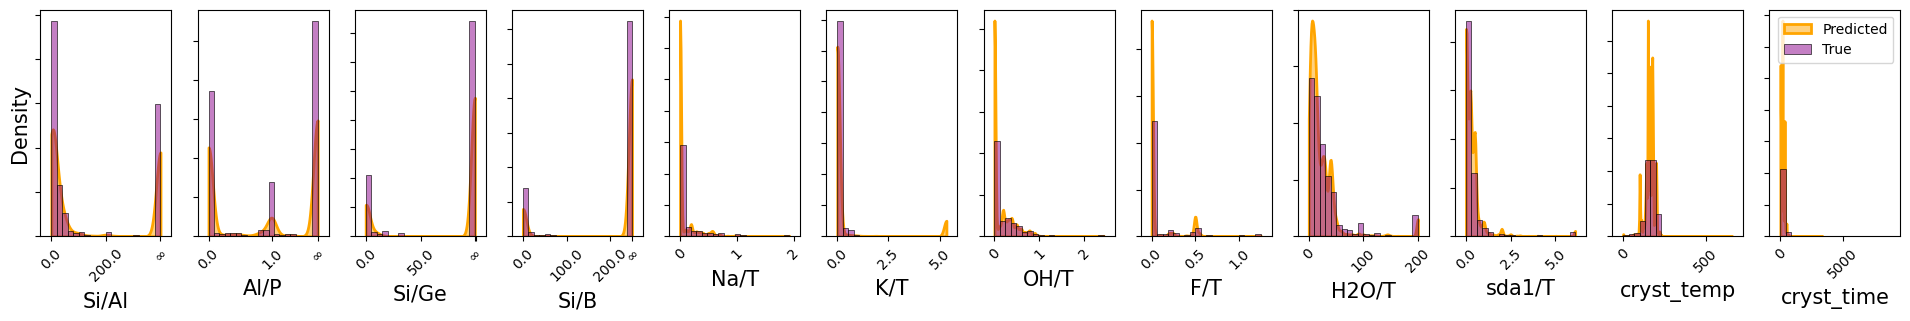

In [12]:
utils.compare_gel_conds([syn_pred, syn_true], ['Predicted', 'True'], [True, False], [False, True], ['orange', 'darkmagenta'], common_norm=True, alpha=0.5)

# System-splits

### Zeolite-aggregated systems

In [13]:
# Top 10 most/least common zeolites in test set
zeo_systems = list(syn_true['zeo'].value_counts().index)
count = 0
mmd_zeo_agg = {} # Dict of MMDs for each zeolite
for zeo in zeo_systems:
# for zeo in reversed(zeo_systems):
    if zeo != 'Dense/Amorphous':
        # print(zeo)
        sys_syn_pred, sys_syn_true = syn_pred[syn_pred['zeo'] == zeo], syn_true[syn_true['zeo'] == zeo]
        sys_syn_pred_scaled, sys_syn_true_scaled = syn_pred_scaled[syn_pred_scaled['zeo'] == zeo], syn_true_scaled[syn_true_scaled['zeo'] == zeo]
        mmd = maximum_mean_discrepancy(sys_syn_pred_scaled[dataset.ratio_names+dataset.cond_names], sys_syn_true_scaled[dataset.ratio_names+dataset.cond_names])
        mmd_zeo_agg[zeo] = mmd
        # print('MMD:', mmd)
        # utils.compare_gel_conds([sys_syn_pred, sys_syn_true], ['Predicted', 'True'], [True, False], [False, True], ['tab:orange', 'tab:blue'], common_norm=True, alpha=0.5)
        count += 1
    # if count == 10:
    #     break
mmd_zeo_agg_df = pd.DataFrame({'zeo': mmd_zeo_agg.keys(), 'MMD': mmd_zeo_agg.values()}).sort_values('MMD')
mmd_mean, mmd_std = mmd_zeo_agg_df['MMD'].mean(), mmd_zeo_agg_df['MMD'].std()
with open(f"runs/{configs['model_type']}/{configs['split']}/{configs['fname']}/mmd_zeo_agg.json", "w") as outfile:
    json.dump({'MMD mean': mmd_mean, 'MMD std': mmd_std}, outfile, indent=4)
print('Mean MMD:', mmd_mean, 'Std MMD:', mmd_std)

Mean MMD: 1.688326710636176 Std MMD: 1.4233487513141097


<Figure size 360x360 with 0 Axes>

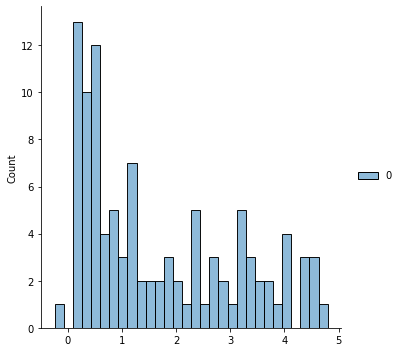

In [14]:
import seaborn as sns
plt.figure(figsize=(5,5))
sns.displot(mmd_zeo_agg.values(), bins=30)
plt.show()

MMD: 0.274619460105896


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


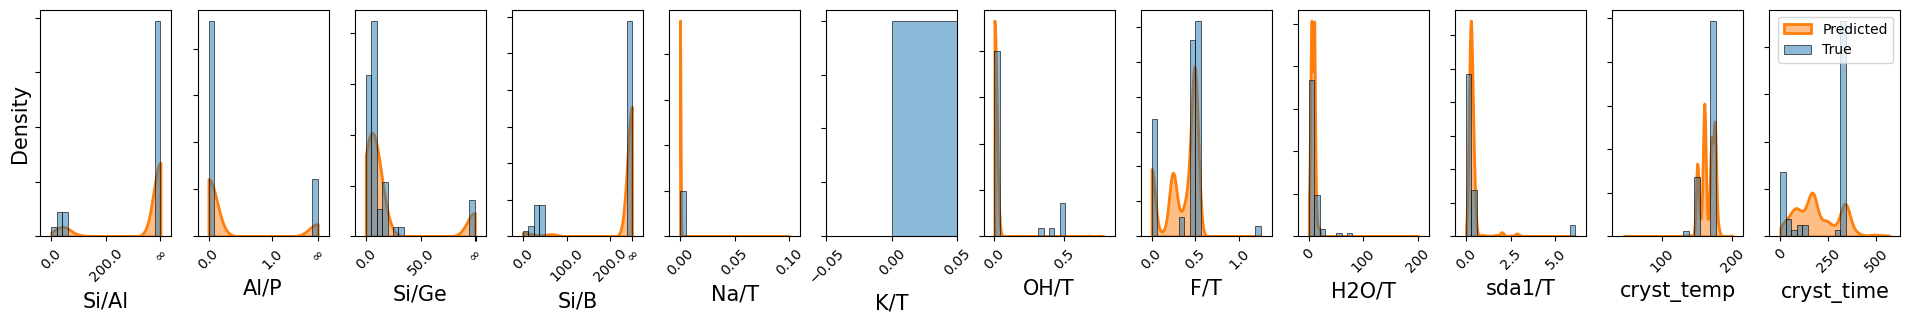

In [15]:
# BEC - observe Si/Ge and F/T
zeo = 'BEC'
sys_syn_pred, sys_syn_true = syn_pred[syn_pred['zeo'] == zeo], syn_true[syn_true['zeo'] == zeo]
sys_syn_pred_scaled, sys_syn_true_scaled = syn_pred_scaled[syn_pred_scaled['zeo'] == zeo], syn_true_scaled[syn_true_scaled['zeo'] == zeo]
print('MMD:', maximum_mean_discrepancy(sys_syn_pred[dataset.ratio_names+dataset.cond_names], sys_syn_true[dataset.ratio_names+dataset.cond_names]))
utils.compare_gel_conds([sys_syn_pred, sys_syn_true], ['Predicted', 'True'], [True, False], [False, True], ['tab:orange', 'tab:blue'], common_norm=True, alpha=0.5)

### Zeolite-OSDA system

In [16]:
zeo_osda_systems = list(syn_true[['zeo', 'osda']].value_counts().index)
count = 0
mmd_zeo_osda = {} # Dict of MMDs for each zeolite-osda 
for zeo, osda in zeo_osda_systems:
# for zeo, osda in reversed(zeo_osda_systems):
    if zeo != 'Dense/Amorphous':
        # print(zeo, osda)
        sys_syn_pred, sys_syn_true = syn_pred[(syn_pred['zeo'] == zeo) & (syn_pred['osda'] == osda)], syn_true[(syn_true['zeo'] == zeo) & (syn_true['osda'] == osda)]
        sys_syn_pred_scaled, sys_syn_true_scaled = syn_pred_scaled[(syn_pred_scaled['zeo'] == zeo) & (syn_pred_scaled['osda'] == osda)], syn_true_scaled[(syn_true_scaled['zeo'] == zeo) & (syn_true_scaled['osda'] == osda)]
        mmd = maximum_mean_discrepancy(sys_syn_pred_scaled[dataset.ratio_names+dataset.cond_names], sys_syn_true_scaled[dataset.ratio_names+dataset.cond_names])
        mmd_zeo_osda[(zeo,osda)] = mmd
        # print('MMD:', mmd)
        # utils.compare_gel_conds([sys_syn_pred, sys_syn_true], ['Predicted', 'True'], [True, False], [False, True], ['tab:orange', 'tab:blue'], common_norm=True, alpha=0.5)
        count += 1
    # if count > 15:
    #     break
mmd_zeo_osda_df = pd.DataFrame({'zeo_osda': mmd_zeo_osda.keys(), 'MMD': mmd_zeo_osda.values()}).sort_values('MMD')
mmd_mean, mmd_std = mmd_zeo_osda_df['MMD'].mean(), mmd_zeo_osda_df['MMD'].std()
with open(f"runs/{configs['model_type']}/{configs['split']}/{configs['fname']}/mmd_zeo_osda.json", "w") as outfile:
    json.dump({'MMD mean': mmd_mean, 'MMD std': mmd_std}, outfile, indent=4)
print('Mean MMD:', mmd_mean, 'Std MMD:', mmd_std)

Mean MMD: 2.1170813371244983 Std MMD: 1.3402705481110735


### BEC systems

BEC c1ccc(C[N+]23CCC(CC2)CC3)cc1


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range

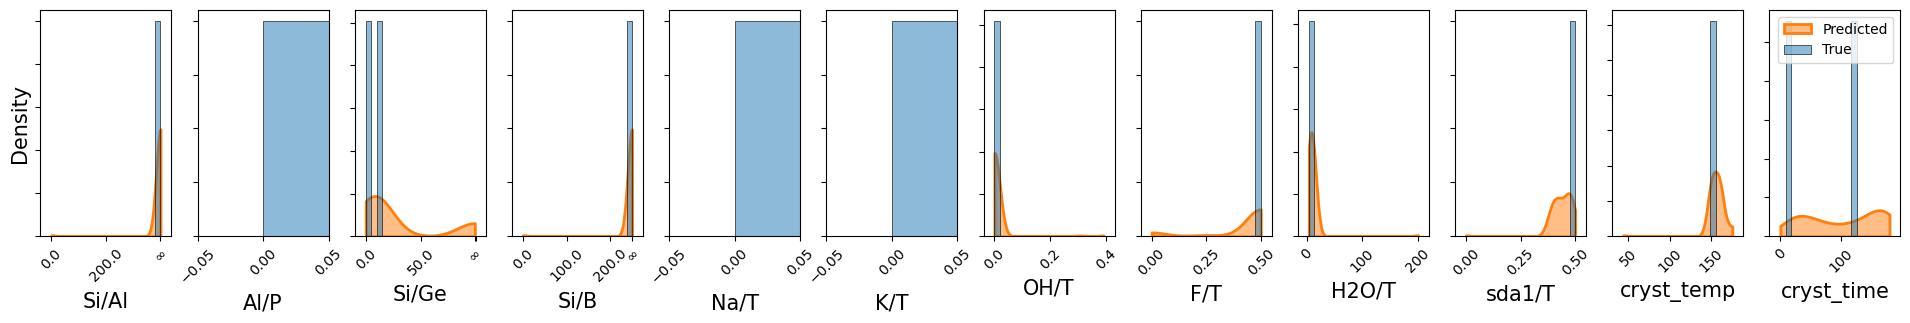

BEC c1cc(C[N+]23CCC(CC2)CC3)ccc1C[N+]12CCC(CC1)CC2


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 250.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_ran

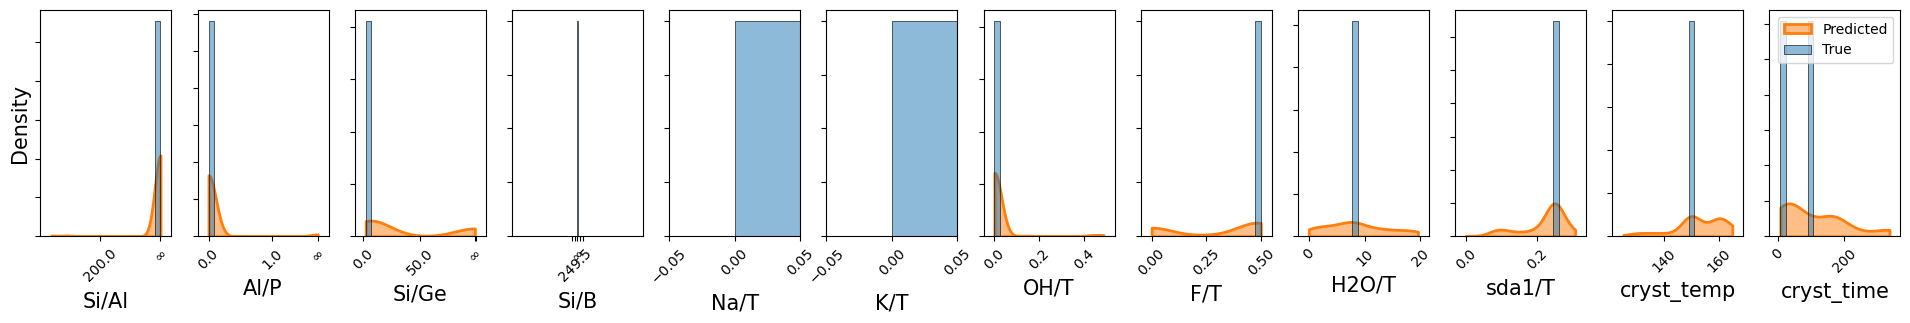

BEC C(CC[N+]12CCN(CC1)CC2)C[N+]12CCN(CC1)CC2


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


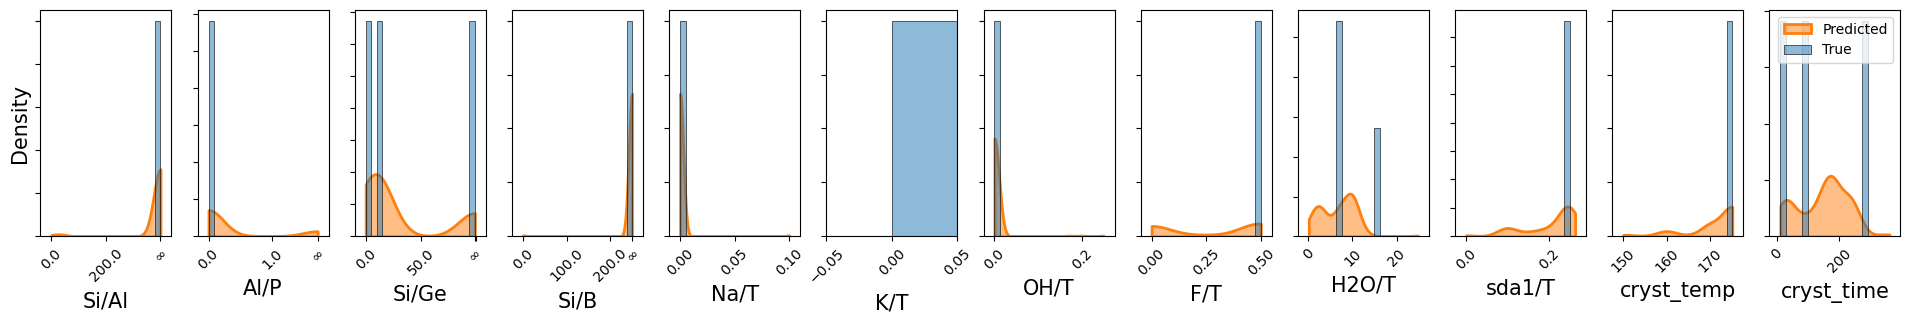

BEC CN(C)CCN(C)C


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range

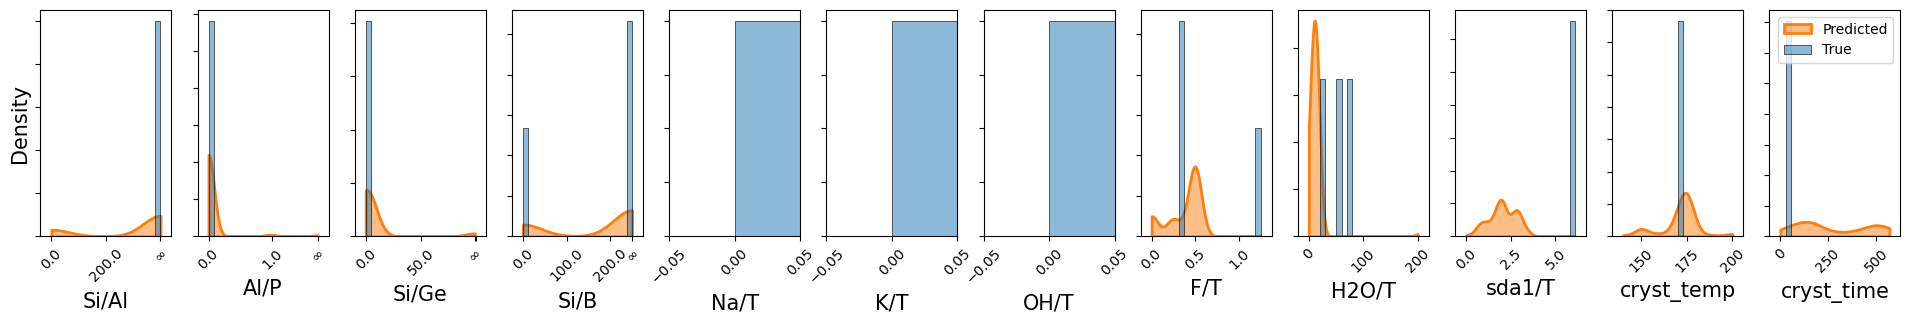

BEC CCC[N+]1(CCC)CCC([N+]2(CCC)CCCC2)CC1


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)


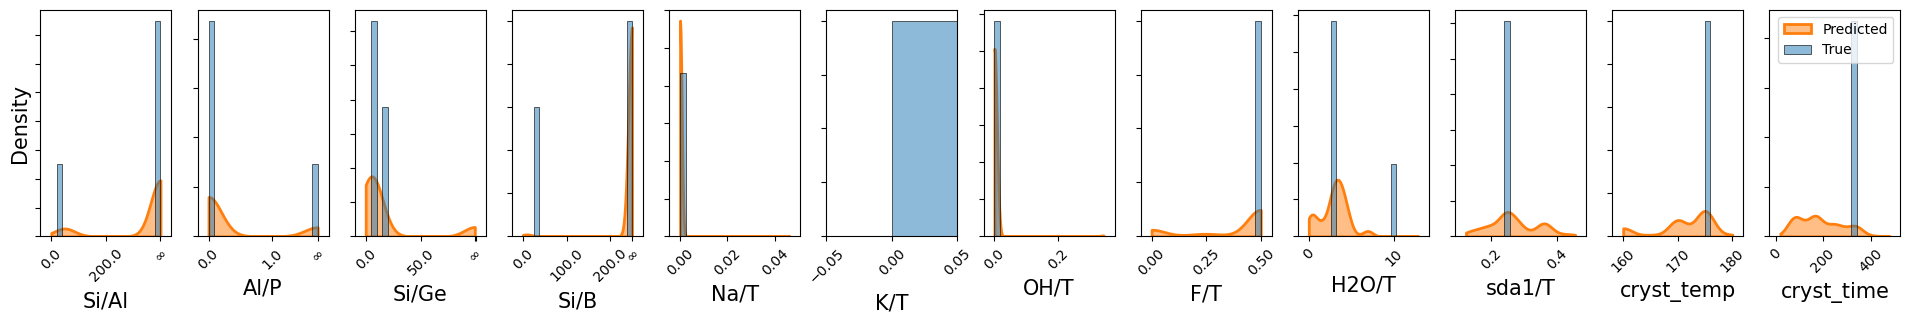

BEC c1ccc(C[N+]23CCN(CC2)CC3)cc1


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range

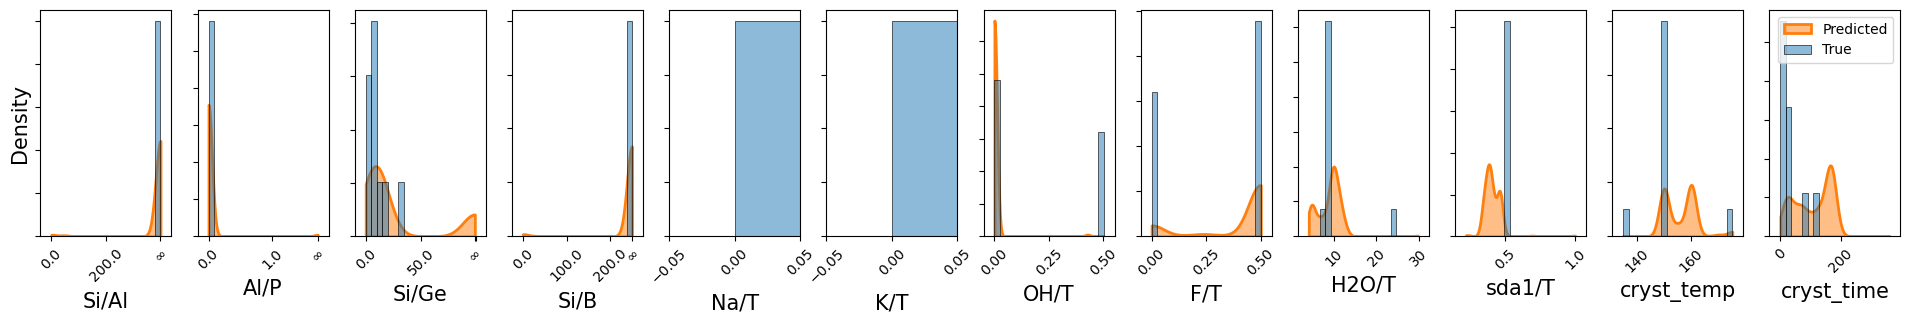

BEC C[N+]1(C)CCC([N+]2(C)CCCC2)CC1


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range

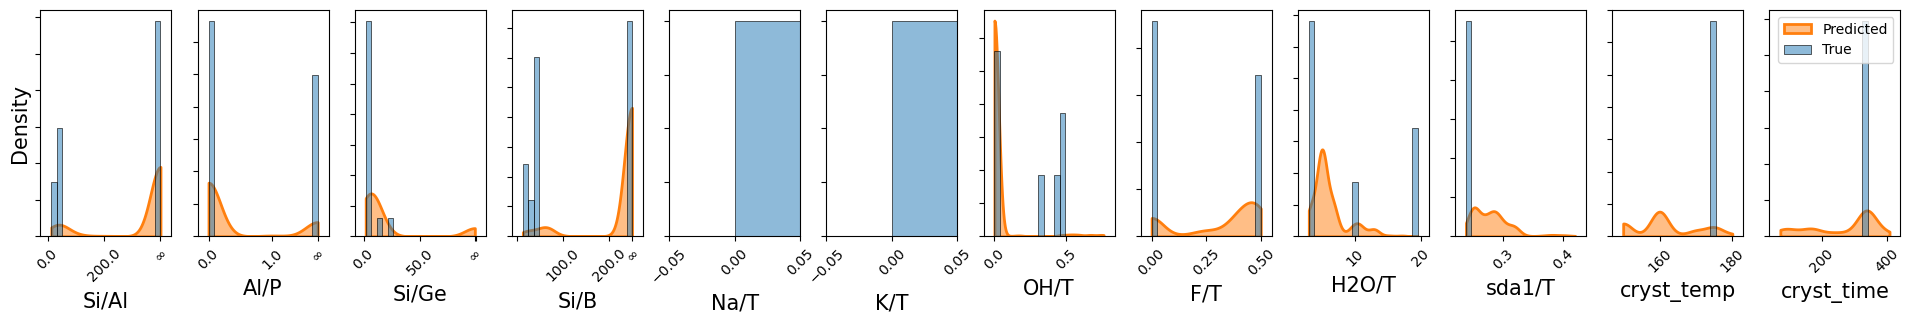

BEC C[N+]1(C)CC2C3C=CC(C2C1)C1C2C[N+](C)(C)CC2C31


/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range)
/home/synthesisproject/anaconda3/envs/zeo_diffusion/lib/python3.10/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jupyter/Elton/Zeolites/zeosyn_gen/data/utils.py:677: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  plt.xlim(col_min-0.1*col_range, col_max+0.1*col_range

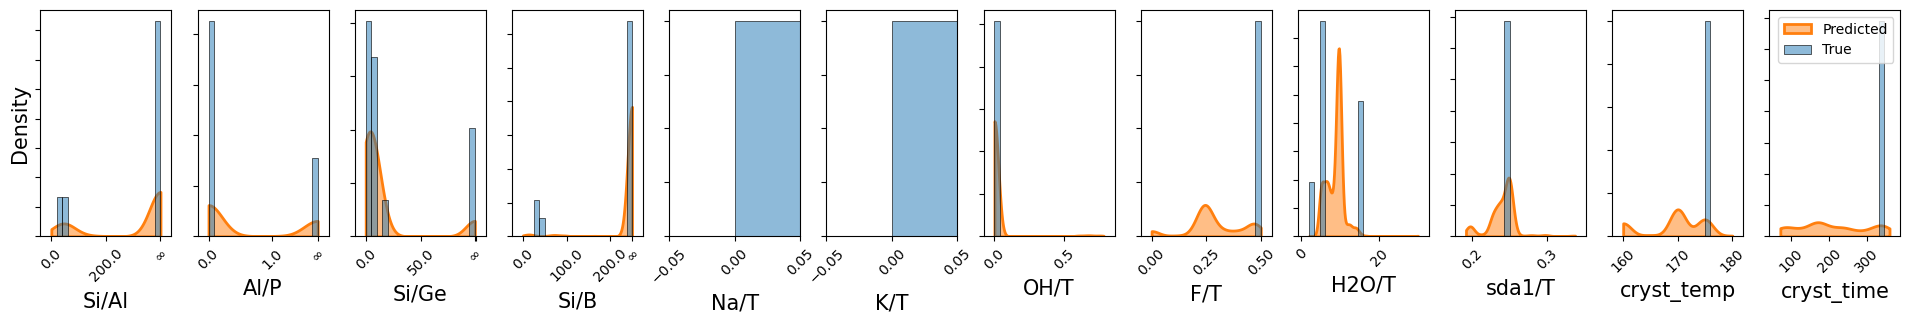

In [17]:
# Check BEC system for Si/Ge and F/T
zeo_osda_systems = list(syn_true[['zeo', 'osda']].value_counts().index)
count = 0
for zeo, osda in reversed(zeo_osda_systems):
    if zeo == 'BEC':
        print(zeo, osda)
        sys_syn_pred = syn_pred[(syn_pred['zeo'] == zeo) & (syn_pred['osda'] == osda)]
        sys_syn_true = syn_true[(syn_true['zeo'] == zeo) & (syn_true['osda'] == osda)]
        utils.compare_gel_conds([sys_syn_pred, sys_syn_true], ['Predicted', 'True'], [True, False], [False, True], ['tab:orange', 'tab:blue'], common_norm=True, alpha=0.5)
        
        count += 1
        if count > 50:
            break